## First Models

First models on the deparment GPU

In [1]:
"""Trains a model on a department machine.

Make sure to copy the data from thingumy to here first.
"""
import logging
import os
import sys
from pathlib import Path

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import layers, optimizers

Using TensorFlow backend.
/gpfs/main/home/lzhu7/elvo-analysis/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
LENGTH, WIDTH, HEIGHT = (120, 120, 64)

VALID_TRAINING_INDICES = []
VALID_VALIDATION_INDICES = []

In [3]:
def configure_logger():
    root_logger = logging.getLogger()
    root_logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    formatter = logging.Formatter(
        fmt='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    root_logger.addHandler(handler)

## Preprocessing


In [4]:
def load_training_data() -> np.array:
    """Returns a 4D matrix of the training data.

     The data is in the form (n_samples, l, w, h). The samples
     are sorted by patient ID.
     """
    arrays = []
    training_filenames = sorted(os.listdir(
        '/home/lzhu7/data/numpy_split/training'))
    for i, filename in enumerate(training_filenames):
        arr = np.load('/home/lzhu7/data/numpy_split/training/' + filename)
        if arr.shape == (LENGTH, WIDTH, HEIGHT):
            arrays.append(arr)
            VALID_TRAINING_INDICES.append(i)
        else:
            logging.info(
                f'training file {filename} has incorrect shape {arr.shape}')
    return np.stack(arrays)


def load_validation_data() -> np.array:
    """Returns a 4D matrix of the validation data.

     The data is in the form (n_samples, l, w, h). The samples
     are sorted by patient ID.
    """
    arrays = []
    validation_filenames = sorted(os.listdir(
        '/home/lzhu7/data/numpy_split/validation'))
    for i, filename in enumerate(validation_filenames):
        arr = np.load('/home/lzhu7/data/numpy_split/validation/' + filename)
        if arr.shape == (LENGTH, WIDTH, HEIGHT):
            arrays.append(arr)
            VALID_VALIDATION_INDICES.append(i)
        else:
            logging.info(
                f'validation file {filename} has incorrect shape {arr.shape}')
    return np.stack(arrays)


def load_labels() -> (np.array, np.array):
    training_df = pd.read_csv('/home/lzhu7/data/training_labels.csv')
    validation_df = pd.read_csv('/home/lzhu7/data/validation_labels.csv')
    training_labels = training_df.sort_values('patient_id')['label'].values
    validation_labels = validation_df.sort_values('patient_id')['label'].values
    return training_labels, validation_labels

In [5]:
configure_logger()
X_train = load_training_data()
logging.info(f'loaded training data with shape {X_train.shape}')
y_train, _ = load_labels()
logging.info(f'loaded training labels with shape {y_train.shape}')
y_train = y_train[VALID_TRAINING_INDICES]
logging.info(f'filtered training labels to shape {y_train.shape}')

2018-06-11 15:22:57,444 - root - INFO - loaded training data with shape (500, 120, 120, 64)
2018-06-11 15:22:57,458 - root - INFO - loaded training labels with shape (500,)
2018-06-11 15:22:57,459 - root - INFO - filtered training labels to shape (500,)


In [6]:
# Uncomment to see validation data
X_valid = load_validation_data()
logging.info(f'loaded validation data with shape {X_valid.shape}')
_, y_valid = load_labels()
logging.info(f'loaded validation labels with shape {y_valid.shape}')
y_valid = y_valid[VALID_VALIDATION_INDICES]
logging.info(f'filtered validation labels to shape {y_valid.shape}')

2018-06-11 15:22:57,882 - root - INFO - validation file LAUIHISOEZIM5ILF.npy has incorrect shape (120, 120, 0)
2018-06-11 15:22:58,844 - root - INFO - loaded validation data with shape (379, 120, 120, 64)
2018-06-11 15:22:58,855 - root - INFO - loaded validation labels with shape (380,)
2018-06-11 15:22:58,856 - root - INFO - filtered validation labels to shape (379,)


## Data Exploration

In [7]:
%matplotlib inline

## More preprocessing

In [8]:
def normalize(X: np.array, mean: float, std: float):
    return (X - mean) / std

In [9]:
def squash_height(X: np.array):
    return X.max(axis=3)

In [10]:
X_mean = X_train.mean()
X_std = X_train.std()
print(X_mean, X_std)

36.98628576605903 217.98102904871755


In [11]:
X_train = normalize(X_train, X_mean, X_std)
print(X_train.mean(), X_train.std())

-4.2368577781972915e-17 0.9999999999999996


In [12]:
X_valid = normalize(X_valid, X_mean, X_std)
print(X_valid.mean(), X_valid.std())

0.028612636609074697 0.9502294290688718


In [13]:
X_train_squashed = np.expand_dims(squash_height(X_train), axis=3)

In [14]:
X_valid_squashed = np.expand_dims(squash_height(X_valid), axis=3)

In [15]:
X_train_squashed.shape

(500, 120, 120, 1)

In [16]:
import matplotlib.pyplot as plt

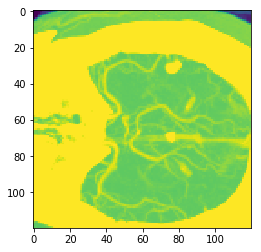

In [17]:
plt.imshow(squash_height(X_valid)[14])

In [18]:
X_train_3d = np.expand_dims(X_train, axis=4)

In [19]:
X_valid_3d = np.expand_dims(X_valid, axis=4)

## Model training

In [20]:
def build_model() -> keras.Model:
    """This initially worked fine.
    """
    model = keras.Sequential()
    model.add(layers.Conv2D(128,
                            (3, 3),
                            activation='relu',
                            input_shape=(LENGTH, WIDTH, HEIGHT)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(1024, (3, 3), activation='relu', use_bias=False, padding='same'))
    model.add(layers.Conv2D(1024, (3, 3), activation='relu', use_bias=False, padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu', use_bias=False))
    model.add(layers.Dense(1024, activation='relu', use_bias=False))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid', use_bias=False))

    model.compile(optimizer=optimizers.Adam(lr=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [21]:
def build_model_squashed() -> keras.Model:
    """This doesn't work well
    """
    model = keras.Sequential()
    model.add(layers.Conv2D(64,
                            (3, 3),
                            activation='relu',
                            input_shape=(LENGTH, WIDTH, HEIGHT)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizers.Adam(lr=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [25]:
def build_model_3d() -> keras.Model:
    model = keras.Sequential()
    model.add(layers.Conv3D(64,
                            (3, 3, 3),
                            activation='relu',
                            input_shape=(LENGTH, WIDTH, HEIGHT, 1)))
    model.add(layers.MaxPool3D())
    model.add(layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool3D())
    model.add(layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool3D())
    model.add(layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool3D())
    model.add(layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPool3D())
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu', use_bias=False))
    model.add(layers.Dense(1024, activation='relu', use_bias=False))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid', use_bias=False))

    model.compile(optimizer=optimizers.Adam(lr=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [26]:
model_3d = build_model_3d()
model_3d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 118, 118, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 59, 59, 31, 64)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 59, 59, 31, 128)   221312    
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 29, 29, 15, 128)   0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 29, 29, 15, 256)   884992    
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 29, 29, 15, 256)   1769728   
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 14, 14, 7, 256)    0         
__________

In [ ]:
model_3d.fit(X_train_3d[0:500], y_train[0:500], batch_size=32, epochs=10, validation_data=(X_valid_3d, y_valid))

Train on 500 samples, validate on 379 samples
Epoch 1/10


In [ ]:
# model.predict(X_train[0:10])

In [ ]:
# model.predict(X_valid[0:10])

In [ ]:
import time
model.save(f'model-{time.time()}.hdf5')